# POTATO DISEASE DETECTION - MODEL TRAINING

##### IMPORTING ALL THE DEPENDENCIES

In [99]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

##### DEFINING CONSTANTS

In [100]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30 # This value can be adjusted as per the accuracy.
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

##### IMPORTING DATA INTO TENSORFLOW DATASET OBJECT

In [101]:
# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset", # Path to the dataset
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [102]:
CLASS_NAMES = dataset.class_names
print(CLASS_NAMES)

['early_blight', 'healthy', 'late_blight']


##### VISUALIZING SOME DATA OF OUR DATASET TO CHECK IF IT IS LOADED CORRECTLY

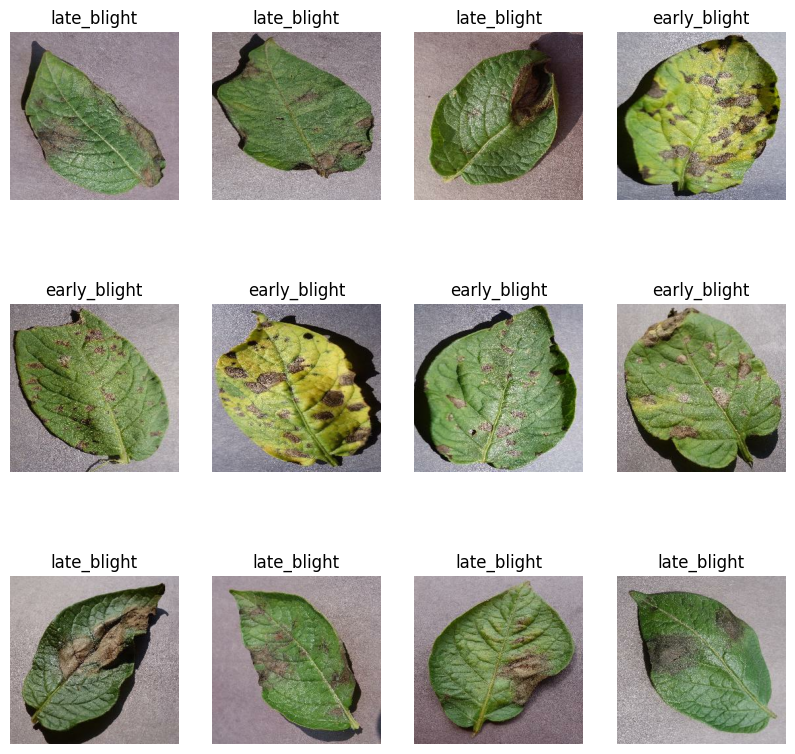

In [103]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels_batch[i]])
        plt.axis("off")

##### Function to Split Dataset:
We are bifurcating the dataset into 3 subsets, namely:
1. Training: Dataset that we will use while training the model. (80%)
2. Validation: Dataset that we will test against while training the model. (10%)
3. Test: Dataset we will test against after we trained a model. (10%)

In [104]:
def get_individual_dataset(
        data_set,
        training_dataset_size = 0.8,
        validation_dataset_size = 0.1,
        test_dataset_size = 0.1,
        shuffle = True,
        shuffle_size = 10000
):
    # Check that the split add up to 1.
    assert (training_dataset_size + validation_dataset_size + test_dataset_size) == 1

    # Get the size of the dataset.
    m_data_set_size = len(data_set)

    # Shuffle the dataset.
    if shuffle:
        data_set = data_set.shuffle(shuffle_size, seed = 12)

    # Calculate the sizes of each dataset.
    m_training_size = int(training_dataset_size * m_data_set_size)
    m_validation_size = int(validation_dataset_size * m_data_set_size)
    m_test_size = int(test_dataset_size * m_data_set_size)

    # Split the dataset.
    m_training_dataset = data_set.take(m_training_size)
    m_validation_dataset = data_set.skip(m_training_size).take(m_validation_size)
    m_test_dataset = data_set.skip(m_training_size).skip(m_validation_size).take(m_test_size)

    return m_training_dataset, m_validation_dataset, m_test_dataset

# Get the individual datasets.
training_dataset, validation_dataset, test_dataset = get_individual_dataset(dataset)

##### Caching, Shuffling, and Prefetching all the individual Dataset's.

In [105]:
training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Building the Model.

##### Creating a layer that will resize and normalize the data

In [106]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

##### Creating a Data Augmentation Layer - Because we have less data in our dataset.

In [107]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

##### Applying the Data Augmentation Layer to our Training Dataset.

In [108]:
training_dataset = training_dataset\
    .map(lambda x, y: (data_augmentation(x, training=True), y))\
    .prefetch(buffer_size=tf.data.AUTOTUNE)

##### MODEL ARCHITECTURE - Using Convolutional Neural Network (CNN)

In [109]:
# filters value can be adjusted as per the accuracy.
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64,  kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64,  kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(), # Flattening the 2D arrays for fully connected layers.
    layers.Dense(64, activation='relu'), # Add a dense layer with 64 neurons.
    layers.Dense(len(CLASS_NAMES), activation='softmax'), # Output Layer - 3 Classes.
])

model.build(input_shape=INPUT_SHAPE)
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_30 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (32, 60, 60, 64)        

##### COMPILING THE MODEL

In [110]:
model.compile(
    optimizer='adam', # Most popular optimizer.
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [111]:
history = model.fit(
    training_dataset,
    batch_size = BATCH_SIZE,
    validation_data = validation_dataset,
    verbose = 1,
    epochs = EPOCHS,
)

Epoch 1/30
54/54 [==============================] - 129s 2s/step - loss: 0.9086 - accuracy: 0.4803 - val_loss: 0.9349 - val_accuracy: 0.4479
Epoch 2/30
54/54 [==============================] - 133s 2s/step - loss: 0.7217 - accuracy: 0.6701 - val_loss: 0.6028 - val_accuracy: 0.6979
Epoch 3/30
54/54 [==============================] - 136s 3s/step - loss: 0.4577 - accuracy: 0.8142 - val_loss: 0.3885 - val_accuracy: 0.8281
Epoch 4/30
54/54 [==============================] - 134s 2s/step - loss: 0.3861 - accuracy: 0.8374 - val_loss: 0.2735 - val_accuracy: 0.9010
Epoch 5/30
54/54 [==============================] - 130s 2s/step - loss: 0.3487 - accuracy: 0.8611 - val_loss: 0.2865 - val_accuracy: 0.8802
Epoch 6/30
54/54 [==============================] - 129s 2s/step - loss: 0.2723 - accuracy: 0.8860 - val_loss: 0.4414 - val_accuracy: 0.8438
Epoch 7/30
54/54 [==============================] - 139s 3s/step - loss: 0.2291 - accuracy: 0.9034 - val_loss: 0.2466 - val_accuracy: 0.9010
Epoch 8/30
54

In [112]:
# Testing model accuracy with our testing dataset.
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Model Accuracy: {}%".format(round(test_accuracy, 4) * 100))

6/6 [==============================] - 5s 556ms/step - loss: 0.0374 - accuracy: 0.9896
Model Accuracy: 98.96000000000001%


##### Plotting the Accuracy and Loss of the Model.

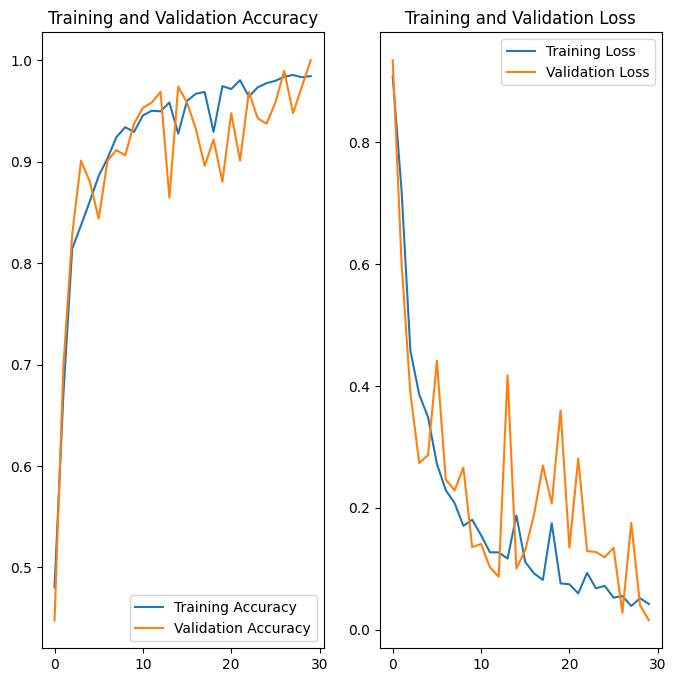

In [113]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history.history['loss'], label='Training Loss')
plt.plot(range(EPOCHS), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##### Run predictions on the sample image given to our model.

1/1 [==============================] - 1s 961ms/step
Actual Class:  early_blight
Predicted Class: early_blight


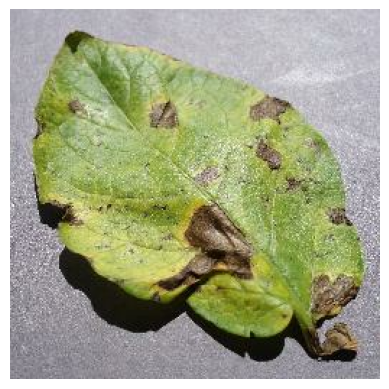

In [114]:
for images_batch, labels_batch in test_dataset.take(1):
    first_image = images_batch[0].numpy().astype('uint8') # Get First Image From Batch.
    actual_class = CLASS_NAMES[labels_batch[0].numpy()] # Get it's actual class name.
    plt.imshow(first_image)
    plt.axis("off")
    batch_prediction = model.predict(images_batch) # Predict the class of the image batch.
    predicted_class = CLASS_NAMES[np.argmax(batch_prediction[0])]

    print("Actual Class: ", actual_class)
    print("Predicted Class:", predicted_class)

##### Saving the Model.

In [115]:
model.save(f"../models")

INFO:tensorflow:Assets written to: ../models\assets


INFO:tensorflow:Assets written to: ../models\assets
